In [54]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import StringLookup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [89]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.layers import Embedding
from keras.layers import Activation
from keras.layers import Add, Activation, Lambda

In [39]:
dataset = pd.read_csv('train.csv')
dataset = dataset[:10000]

In [40]:
user_ids = dataset["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = dataset["itemId"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
dataset["user"] = dataset["userId"].map(user2user_encoded)
dataset["item"] = dataset["itemId"].map(item2item_encoded)

In [16]:
dataset.head()

,userId,itemId,rating,date,user,item
0,cgexjc,682978,4,2017-08-13 13:23:35,0,0
1,cgexjc,320898,4,2019-01-18 15:56:07,0,1
2,cgexjc,29028,4,2017-08-13 14:03:55,0,2
3,cgexjc,399148,5,2017-08-13 13:59:51,0,3
4,cgexjc,734055,4,2019-01-18 15:37:29,0,4


In [41]:
train, test = train_test_split(dataset, test_size=0.2, random_state=42)

In [42]:
n_users = len(dataset.user.unique())
n_item = len(dataset.item.unique())

In [43]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras.models import Model

In [44]:
item_input = Input(shape=[1], name="item-Input")
item_embedding = Embedding(n_item+1, 5, name="item-Embedding")(item_input)
item_vec = Flatten(name="Flatten-items")(item_embedding)

In [45]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

In [46]:
prod = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
model = Model([user_input, item_input], prod)
model.compile('adam', 'mean_squared_error')

In [47]:
history = model.fit([train.user, train.item], train.rating, epochs=10, verbose=1)


Epoch 1/10
250/250 [==============================] - 9s 4ms/step - loss: 12.8456
Epoch 2/10
250/250 [==============================] - 1s 3ms/step - loss: 12.7909
Epoch 3/10
250/250 [==============================] - 1s 2ms/step - loss: 12.3667
Epoch 4/10
250/250 [==============================] - 1s 3ms/step - loss: 11.2647
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 9.6701
Epoch 6/10
250/250 [==============================] - 1s 3ms/step - loss: 7.9544
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 6.4106
Epoch 8/10
250/250 [==============================] - 1s 2ms/step - loss: 5.1727
Epoch 9/10
250/250 [==============================] - 1s 2ms/step - loss: 4.2418
Epoch 10/10
250/250 [==============================] - 1s 2ms/step - loss: 3.5465


# Visualizing embeddings

In [11]:
# Extract embeddings
item_em = model.get_layer('item-Embedding')
item_em_weights = item_em.get_weights()[0]

In [14]:
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE

<AxesSubplot: >

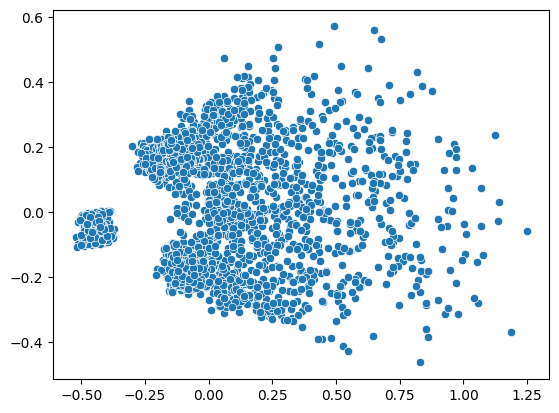

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(item_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2971 samples in 0.036s...
[t-SNE] Computed neighbors for 2971 samples in 0.167s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2971
[t-SNE] Computed conditional probabilities for sample 2000 / 2971
[t-SNE] Computed conditional probabilities for sample 2971 / 2971
[t-SNE] Mean sigma: 0.033487
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.149361
[t-SNE] KL divergence after 300 iterations: 1.727633


<AxesSubplot: >

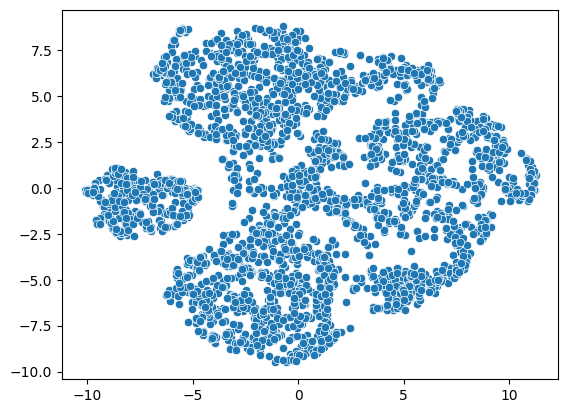

In [15]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(item_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Making Recommendations

Because all the data is not used, the following code will encounter an error

In [19]:
# Creating dataset for making recommendations for the first user
#item_data = np.array(list(set(dataset.itemId)))
# user = np.array([1 for i in range(len(item_data))])
# predictions = model.predict([user, item_data])
# predictions = np.array([a[0] for a in predictions])
# recommended_item_ids = (-predictions).argsort()[:5]
# print(recommended_item_ids)
# print(predictions[recommended_item_ids])

In [52]:
g = dataset.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = dataset.groupby('itemId')['rating'].count()
top_item = g.sort_values(ascending=False)[:15]
top_r = dataset.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_item, rsuffix='_r', how='inner', on='itemId')
pd.crosstab(top_r.userId, top_r.itemId, top_r.rating, aggfunc=np.sum)

C:\Users\aghebati.pc\AppData\Local\Temp\ipykernel_9320\1911005652.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_item = g.sort_values(ascending=False)[:15]


itemId,138996,176117,189667,336693,351940,399148,441892,455590,625670,701603,754693,761740,934793,960894,989650
userId,,,,,,,,,,,,,,,
ansxpb,4.0,2.0,2.0,3.0,2.0,1.0,2.0,3.0,NaN,4.0,NaN,3.0,3.0,2.0,NaN
cgexjc,4.0,4.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,4.0
gyjlqc,3.0,4.0,3.0,4.0,3.0,2.0,3.0,3.0,3.0,3.0,4.0,4.0,5.0,NaN,NaN
irwcmp,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0
kghhrg,NaN,5.0,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
pawbrd,4.0,NaN,2.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,NaN,4.0,5.0,4.0
pjxjgy,3.0,4.0,3.0,4.0,3.0,4.0,5.0,5.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN
qwasoh,4.0,4.0,4.0,3.0,5.0,NaN,2.0,4.0,5.0,3.0,3.0,3.0,4.0,4.0,NaN
txdmvc,4.0,NaN,NaN,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0


In [65]:
user_enc = LabelEncoder()
dataset['user'] = user_enc.fit_transform(dataset['userId'].values)
n_users = dataset['user'].nunique()
item_enc = LabelEncoder()
dataset['item'] = item_enc.fit_transform(dataset['itemId'].values)
n_items = dataset['item'].nunique()
dataset['rating'] = dataset['rating'].values.astype(np.float32)
min_rating = min(dataset['rating'])
max_rating = max(dataset['rating'])
n_users, n_items, min_rating, max_rating


(98, 2970, 1.0, 5.0)

In [66]:
X = dataset[['user', 'item']].values
y = dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 2), (1000, 2), (9000,), (1000,))

In [67]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [68]:
def RecommenderV1(n_users, n_items, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    item = Input(shape=(1,))
    m = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [69]:
model = RecommenderV1(n_users, n_items, n_factors)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        4900        ['input_3[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 50)        148500      ['input_4[0][0]']                
                                                                                            

C:\Users\aghebati.pc\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [70]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
141/141 [==============================] - 10s 54ms/step - loss: 12.8571 - val_loss: 13.0602
Epoch 2/5
141/141 [==============================] - 1s 5ms/step - loss: 12.5484 - val_loss: 12.8803
Epoch 3/5
141/141 [==============================] - 1s 5ms/step - loss: 11.7585 - val_loss: 12.0732
Epoch 4/5
141/141 [==============================] - 1s 5ms/step - loss: 9.9037 - val_loss: 10.1369
Epoch 5/5
141/141 [==============================] - 1s 5ms/step - loss: 7.0689 - val_loss: 7.6200


In [87]:
def RecommenderNet(n_users, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors)(user)
    
    item = Input(shape=(1,))
    m = Embedding(n_items, n_factors)(item)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [90]:
model = RecommenderNet(n_users, n_items, n_factors, min_rating, max_rating)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 50)        4900        ['input_17[0][0]']               
                                                                                                  
 embedding_14 (Embedding)       (None, 1, 50)        148500      ['input_18[0][0]']               
                                                                                            

In [91]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
141/141 [==============================] - 4s 10ms/step - loss: 1.3484 - val_loss: 1.2231
Epoch 2/5
141/141 [==============================] - 1s 7ms/step - loss: 1.3268 - val_loss: 1.2229
Epoch 3/5
141/141 [==============================] - 1s 6ms/step - loss: 1.3224 - val_loss: 1.2216
Epoch 4/5
141/141 [==============================] - 1s 7ms/step - loss: 1.3188 - val_loss: 1.2227
Epoch 5/5
141/141 [==============================] - 1s 6ms/step - loss: 1.3164 - val_loss: 1.2216


In [94]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV2(n_users, n_items, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    item = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(item)
    mb = EmbeddingLayer(n_items, 1)(item)
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, item], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [95]:
model = RecommenderV2(n_users, n_movies, n_factors, min_rating, max_rating)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_17 (Embedding)       (None, 1, 50)        4900        ['input_21[0][0]']               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 50)        148500      ['input_22[0][0]']               
                                                                                            

In [96]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
141/141 [==============================] - 2s 7ms/step - loss: 1.4338 - val_loss: 1.2962
Epoch 2/5
141/141 [==============================] - 1s 5ms/step - loss: 1.2556 - val_loss: 1.2095
Epoch 3/5
141/141 [==============================] - 1s 5ms/step - loss: 1.0598 - val_loss: 1.1309
Epoch 4/5
141/141 [==============================] - 1s 5ms/step - loss: 0.8365 - val_loss: 1.0613
Epoch 5/5
141/141 [==============================] - 1s 5ms/step - loss: 0.6208 - val_loss: 1.0049
